In [9]:
import psycopg2
import pandas as pd
from sqlalchemy import create_engine


In [10]:
host = 'localhost'
port = '5432'
dbname = 'mavenfuzzyfactory'
user = 'postgres'
password = 'Bismillah123!'

# string koneksi menggunakan SQLAlchemy
connection_string = f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}"

# membuat engine SQLAlchemy
engine = create_engine(connection_string)

**1. Perusahaan ingin melihat traffic sebelum tanggal 13 April 2012. Tampilkan utm source, utm campaign, dan http referer.**

In [11]:
query = '''
    SELECT 
        utm_source,
        utm_campaign,
        http_referer,
        COUNT(Date(created_at)) AS session
    FROM website_sessions
    WHERE Date(created_at) < '2012-04-13'
    GROUP BY 1, 2, 3
    ORDER BY 4 DESC
'''

# query = '''SELECT * FROM website_sessions'''
pd.read_sql(query, engine)

,utm_source,utm_campaign,http_referer,session
0,gsearch,nonbrand,https://www.gsearch.com,3757
1,None,None,None,32
2,gsearch,brand,https://www.gsearch.com,30
3,None,None,https://www.gsearch.com,30
4,bsearch,brand,https://www.bsearch.com,7
5,None,None,https://www.bsearch.com,7


**2. Menghitung Conversion Rate per tanggal 14 April 2012 dimana source adalah gsearch dan campaign adalah nonbrand**

In [12]:
query = '''
	WITH test AS (
		SELECT
			utm_source,
			utm_campaign,
			order_id
		FROM website_sessions AS ws
		LEFT JOIN orders USING(website_session_id)
		WHERE Date(ws.created_at) < '2012-04-14' AND utm_source = 'gsearch' AND utm_campaign = 'nonbrand'
	)
	select
		COUNT(utm_source) AS sessions,
		COUNT(order_id) AS orders,
		COUNT(order_id)::FLOAT / COUNT(utm_source) * 100 AS session_to_order_cvr
	FROM test

'''

# query = '''SELECT * FROM website_sessions'''
pd.read_sql(query, engine)

,sessions,orders,session_to_order_cvr
0,3895,112,2.875481


**3. Analysis pada tanggal 11 may 2012 volume traffic dari gsearch nonbrand**

In [13]:
query = '''
    SELECT
        EXTRACT(WEEK FROM created_at) AS weeks,
        DATE_TRUNC('week', created_at) AS week_start_date,
        COUNT(website_session_id) AS session
    FROM
        website_sessions
    WHERE 
        created_at < '2012-05-11' AND 
        utm_source = 'gsearch' AND 
        utm_campaign = 'nonbrand'
    GROUP BY 1, 2
    ORDER BY 1
'''

pd.read_sql(query, engine)

,weeks,week_start_date,session
0,12.0,2012-03-19,965
1,13.0,2012-03-26,980
2,14.0,2012-04-02,1138
3,15.0,2012-04-09,967
4,16.0,2012-04-16,611
5,17.0,2012-04-23,589
6,18.0,2012-04-30,682
7,19.0,2012-05-07,471


**4. Conversion rate untuk gsearc nonbrand berdasarkan jenis perangkat**

In [14]:
query = ''' 
    SELECT
        device_type,
        COUNT(device_type) AS sessions,
        COUNT(order_id) AS orders,
        COUNT(order_id)::FLOAT / COUNT(device_type) * 100 AS conversion_rate
    FROM website_sessions as ws 
    LEFT JOIN orders USING(website_session_id)
    WHERE ws.created_at < '2012-05-12' AND utm_source = 'gsearch' AND utm_campaign = 'nonbrand'
    GROUP BY 1
'''

pd.read_sql(query, engine)

,device_type,sessions,orders,conversion_rate
0,desktop,3986,148,3.712995
1,mobile,2548,24,0.941915


**5.  Melihat halaman website mana yang sering dilihat selama website berjalan hingga 10 juni 2012**

In [15]:
query = ''' 
    SELECT
        pageview_url,
        COUNT(DISTINCT website_session_id) AS total_sessions
    FROM website_pageviews
    WHERE created_at < '2012-06-10'
    GROUP BY 1
    ORDER BY 2 DESC
'''

pd.read_sql(query, engine)

,pageview_url,total_sessions
0,/home,10469
1,/products,4275
2,/the-original-mr-fuzzy,3067
3,/cart,1315
4,/shipping,873
5,/billing,719
6,/thank-you-for-your-order,309


**6. Halaman pertama yang paling banyak dilihat /dibuka oleh user setiap masuk ke website pada tanggal 13 juni 2012**

In [16]:
query = ''' 
    WITH first_view_url AS (
        SELECT
            DISTINCT(website_session_id),
            FIRST_VALUE(pageview_url) OVER(PARTITION BY website_session_id ORDER BY created_at ASC) AS first_view
        FROM website_pageviews
        WHERE created_at < '2012-06-13'
    )
    SELECT 
        first_view,
        COUNT(*) AS session_hitting_page 
    FROM first_view_url
    GROUP BY 1
'''

pd.read_sql(query, engine)

,first_view,session_hitting_page
0,/home,10865


**7. Menghitung bounce rate dari halaman home page pada tanggal 14 juni 2012**

In [25]:
query = ''' 
    WITH user_session_count AS (
        SELECT
            website_session_id,
            COUNT(pageview_url) AS session_count
        FROM website_pageviews
        WHERE created_at < '2012-06-14'
        GROUP BY 1
    )
    SELECT
        COUNT(website_session_id) AS total_session,
        COUNT(
            CASE
                WHEN session_count = 1 THEN website_session_id
            END
        ) AS bounce_session,
        COUNT(
            CASE
                WHEN session_count = 1 THEN website_session_id
            END
        )::FLOAT /  COUNT(website_session_id) * 100 AS bounce_rate

    FROM user_session_count
'''

pd.read_sql(query, engine)

,total_session,bounce_session,bounce_rate
0,11048,6538,59.178132


**8. Menghitung bounce rate antara /lander-1 dan /home. Session di hitung semenjak periode /lander-1 mulai dijalankan hingga 22 july 2012** 

In [ ]:
query = ''' 
    -- tanggal mulainya session lander
    WITH session_lander_start AS (
        SELECT 
            MIN(DATE(created_at))
        FROM website_pageviews
        WHERE pageview_url = '/lander-1'
    ),
    -- mendapatkan user_session
    user_session AS (
        SELECT
            wp.website_session_id,
            pageview_url,
            FIRST_VALUE(pageview_url) OVER(PARTITION BY website_session_id ORDER BY wp.created_at ASC) AS first_pageview
        FROM 
            website_pageviews AS wp
        JOIN 
            website_sessions AS ws USING(website_session_id)
        WHERE wp.created_at BETWEEN (SELECT * FROM session_lander_start) AND '2012-07-29' 
            AND utm_source = 'gsearch' 
            AND utm_campaign = 'nonbrand'
    )
    SELECT
        first_pageview AS landing_page,
        COUNT(website_session_id) AS total_session,
        COUNT(
            CASE
                WHEN total_session = 1 THEN website_session_id
            END
        ) AS bounce_session,
        COUNT(
            CASE
                WHEN total_session = 1 THEN website_session_id
            END
        ):: FLOAT / COUNT(website_session_id) * 100 AS bounce_rate
    FROM (
        SELECT
            website_session_id,
            first_pageview,
            COUNT(pageview_url) AS total_session
        FROM user_session
        GROUP BY 1, 2
    )
    GROUP BY 1
'''

pd.read_sql(query, engine)

,landing_page,total_session,bounce_session,bounce_rate
0,/home,2295,1344,58.562092
1,/lander-1,2350,1249,53.148936


**9. Conversion Funnel Analysis pada tanggal 5 September 2012**


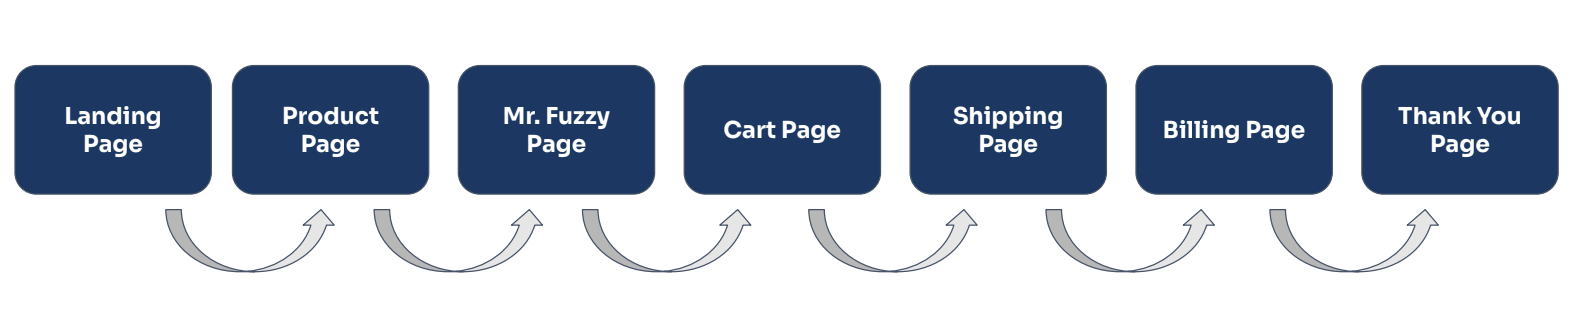

In [85]:
query = ''' 
    WITH total_funnel_count AS(
        SELECT 
            website_session_id,
            COUNT(
                CASE
                    WHEN pageview_url = '/lander-1' THEN website_session_id
                END
            ) AS landing_pg,
            COUNT(
                CASE
                    WHEN pageview_url = '/products' THEN website_session_id
                END
            ) AS product_pg,
            COUNT(
                CASE
                    WHEN pageview_url = '/the-original-mr-fuzzy' THEN website_session_id
                END
            ) AS fuzzy_pg,
            COUNT(
                CASE
                    WHEN pageview_url = '/cart' THEN website_session_id
                END
            ) AS cart_pg,
            COUNT(
                CASE
                    WHEN pageview_url = '/shipping' THEN website_session_id
                END
            ) AS shipping_pg,
            COUNT(
                CASE
                    WHEN pageview_url = '/billing' THEN website_session_id
                END
            ) AS billing_pg,
            COUNT(
                CASE
                    WHEN pageview_url = '/thank-you-for-your-order' THEN website_session_id
                END
            ) AS tq_pg
        FROM website_pageviews AS wp
        JOIN website_sessions AS ws USING(website_session_id)
        WHERE wp.created_at BETWEEN(DATE('2012-09-05'::DATE-INTERVAL '1 month')) AND '2012-09-05'
            AND utm_source = 'gsearch' 
            AND utm_campaign = 'nonbrand'
        GROUP BY 1
    )
    SELECT 
        COUNT(website_session_id) AS sessions,
        SUM(product_pg) / COUNT(website_session_id) AS landing_to_prod_cr,
        SUM(fuzzy_pg) / SUM(product_pg) AS prod_to_fuzzy_cr,
        SUM(cart_pg) / SUM(fuzzy_pg) AS fuzzy_to_cart_cr,
        SUM(shipping_pg) / SUM(cart_pg) AS cart_to_shipping_cr,
        SUM(billing_pg) / SUM(shipping_pg) AS shipping_to_billing_cr,
        SUM(tq_pg) / SUM(billing_pg) AS billing_to_tq_cr
    FROM total_funnel_count
'''

pd.read_sql(query, engine)

,sessions,landing_to_prod_cr,prod_to_fuzzy_cr,fuzzy_to_cart_cr,cart_to_shipping_cr,shipping_to_billing_cr,billing_to_tq_cr
0,4493,0.470732,0.740898,0.435865,0.666179,0.793407,0.437673
